In [1]:
%matplotlib inline

import os
import urllib
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import date2num, DateFormatter, HourLocator, MonthLocator
from datetime import datetime as dt
from datetime import timedelta, time
from pytz import timezone, utc
from pysolar.solar import get_altitude
from pysolar.util import get_sunrise_sunset
from timezonefinder import TimezoneFinder


In [2]:
def manual_inputs():
    """Takes the manual inputs for latitude, longitude and place
    
    Returns tuple (latitude, longitude, place).
    Defaults to Hyderabad location in case of any input errors.
    """
    
    try:
        latitude = float(input('Latitude: '))
        longitude = float(input('Longitude: '))
        place = input('Name of the Place (optional): ')
        location =  (latitude, longitude, place)
    except ValueError:
        print('Latitude and Longitude should be numeric values, using Hyderabad location for now')
        location = get_coordinates('HYD')
        
    return location

def get_coordinates(airport_name):
    """
    Downloads the global airport database from http://www.partow.net/miscellaneous/airportdatabase/index.html
    Returns the Latitude and Longitude for the given airport_name.
    """
      
    airport_db_file = 'GlobalAirportDatabase.txt'
    if not os.path.exists(airport_db_file):
        db_url = 'http://www.partow.net/downloads/GlobalAirportDatabase.zip'
        urllib.request.urlretrieve(db_url, 'GlobalAirportDatabase.zip')
        z = zipfile.ZipFile('GlobalAirportDatabase.zip', 'r')
        z.extractall()
        z.close()
                
    db = open(airport_db_file).readlines()
    airport_info = [x.strip() for x in db if x.split(':')[1] == airport_name]
    airport_info = [x for x in airport_info if float(x.split(':')[-1]) != 0] 
    airport_info = airport_info[0].split(':')
    
    latitude = float(airport_info[-2])
    longitude = float(airport_info[-1])
    place = airport_info[3]
    
    return latitude, longitude, place

def get_tz(latitude, longitude):
    """Returns the timezone for the given latitude and longitude"""
    tz = timezone(TimezoneFinder().timezone_at(lat=latitude, lng=longitude))
    return tz

def get_localized_time(latitude, longitude, time):
    """Returns the timezone aware time for the given latitude and longitude"""
    tz = get_tz(latitude, longitude)
    localized_time = time.astimezone(tz)    
    return localized_time

def time_to_string(time, timedelta=False):
    """Converts the time object to string for easy printing"""
    
    if timedelta:
        try:
            timestring = '%sHr, %sMin' % (time.seconds//3600, (time.seconds//60)%60)
        except: 
            timestring = None
    try:
        timestring = time.strftime('%Y-%m-%d %H:%M')
    except:
        timestring = None

    return timestring
   
def sunrise_sunset_times(latitude, longitude, date):
    """Returns the tuple (sunrise_time, sunset_time) for the given location and date"""
    sunrise_time, sunset_time = get_sunrise_sunset(latitude_deg=latitude, longitude_deg=longitude, when=date)
    return sunrise_time, sunset_time

def get_altitude_times(latitude, longitude, sunrise_time, sunset_time, altitude_for):
    """Finds the time of the sun at specific altitude, using the binary search.
    
    Input:
        latitude: float
        longitude: float
        sunrise_time: timezone aware time
        sunset_time: timezone aware time
        altitude_for: altitude for twilight or max uvb rays. 
                    50 degrees altitude (40 degrees zenith angle) is considered for max uvb rays. 
                    This could be different based on the skin type.
    Returns timezone aware time object
    """
    
    if altitude_for == 'civil_twilight': 
        cutoff = -6
    elif altitude_for == 'nautical_twilight':
        cutoff = -12
    elif altitude_for == 'astronomical_twilight':
        cutoff = -18
    elif altitude_for == 'uvb_for_vitamin_d':
        cutoff = 50
     
    
    if cutoff > 0:
        start = sunrise_time
        end = sunset_time
    else:
        start = sunrise_time.replace(hour=0, minute=0)
        end = sunrise_time
        
    cutoff_low = cutoff
    cutoff_high = cutoff_low + .5
    while (end - start).seconds > 0:
        
        mid = timedelta(seconds=(end - start).seconds/2)
        altitude = get_altitude(latitude, longitude, start)

        if  altitude < cutoff_low: 
            # Sun not reached the altitude yet, move starting time further
            start = start + mid
            
        elif altitude > cutoff_high: 
            # Sun is beyond the cutoff altitude, make it the end point and move starting point
            end = start
            start = start - mid
            
        else: 
            rising_time = start
            break
    else:
        rising_time = np.nan
     
    
    if type(rising_time) != type(sunrise_time):
        setting_time = np.nan
        return rising_time, setting_time
    
    start = rising_time
    if cutoff > 0:
        end = sunset_time
    else:
        end = sunrise_time.replace(hour=23, minute=59)
        
    cutoff_low = cutoff - .5
    cutoff_high = cutoff
    while (end - start).seconds > 0:
        
        mid = timedelta(seconds=(end - start).seconds/2)
        altitude = get_altitude(latitude, longitude, start)

        if  altitude > cutoff_high: 
            # Sun not reached the altitude yet, move starting time further
            start = start + mid
        elif altitude < cutoff_low: 
            # Sun is beyond the cutoff altitude, make it the end point and move starting point
            end = start
            start = end - mid
        else:
            setting_time = start
            break
            
    return rising_time, setting_time
    


In [3]:
def sun_graph(latitude, longitude, place, df, saveplot=False):
    """Plots the graph
    
    Input:
        latitude: float
        longitude: float
        place: string
        df: DataFrame with time objects
        saveplot: saves plot in .png format if True, plots time of the plot if False
    
    """
    
    violet_color = '#842DEC'
    
    # Stripoff timezone info
    graph_df = pd.DataFrame()
    graph_df['day'] = df.day.dt.tz_localize(None)
    graph_df['sunrise'] = df.sunrise.dt.tz_localize(None)
    graph_df['sunset'] = df.sunset.dt.tz_localize(None)
    graph_df['morning_twilight'] = df.morning_twilight.dt.tz_localize(None)
    graph_df['evening_twilight'] = df.evening_twilight.dt.tz_localize(None)
    graph_df['uvbrise'] = df.uvbrise.dt.tz_localize(None)
    graph_df['uvbset'] = df.uvbset.dt.tz_localize(None)
    graph_df['uvbzone'] = df.uvbzone
    
    # Graphs start and end 
    day_start = date2num(dt.combine(dt.date(dt.now()), dt.min.time()))
    day_end = date2num(dt.combine(dt.date(dt.now()), dt.max.time()))
    
    # X axis
    days = [x.date() for x in graph_df.day] 
    
    # Convert to Time of the day from datetime 
    sunrise = date2num([dt.combine(dt.now(), x.time()) for x in graph_df.sunrise])
    sunset = date2num([dt.combine(dt.now(), x.time()) for x in graph_df.sunset])
    morning_twilight = date2num([dt.combine(dt.now(), x.time()) for x in graph_df.morning_twilight])
    evening_twilight = date2num([dt.combine(dt.now(), x.time()) for x in graph_df.evening_twilight])
    
    uvbrise = []
    for i in graph_df.uvbrise:
        try:
            uvbrise.append(date2num(dt.combine(dt.now(), i.time())))
        except:
            uvbrise.append(np.nan)
            
    uvbset = []
    for i in graph_df.uvbset:
        try:
            uvbset.append(date2num(dt.combine(dt.now(), i.time())))
        except:
            uvbset.append(np.nan)
            
    uvbzone = []
    for i in graph_df.uvbzone:
        try:
            uvbzone.append(i.seconds//60)
        except:
            uvbzone.append(0)
            
    fig = plt.figure(figsize=(15, 10))
    
    # Sungraph 4 rows, UVB zone 1 row
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=4, colspan=1) 
    ax1.fill_between(days, day_start, morning_twilight, facecolor='k', alpha=.7)
    ax1.fill_between(days, day_end, evening_twilight, facecolor='k', alpha=.7)
    ax1.fill_between(days, morning_twilight, sunrise, facecolor='k', alpha=.3)
    ax1.fill_between(days, evening_twilight, sunset, facecolor='k', alpha=.3)
    ax1.fill_between(days, uvbrise, uvbset, facecolor=violet_color, alpha=.3)
    
   
    # Mark UVB Zone
    uvb = graph_df.uvbrise.dropna()
    uvbzone_start = uvb.index[0]
    uvbzone_marking_location = uvbzone_start + int(len(uvb)/2)
    
    # hack for Southern hemisphere where summer is during December
    if uvbzone_start == 0 and len(uvb) < 365:
        uvbzone_start = graph_df.uvbrise[graph_df.uvbrise.isnull()][graph_df.uvbrise.shift().notnull()].index[0]
        uvbzone_marking_location = uvbzone_start - 1
    
    uvbzone_marking_x = days[uvbzone_marking_location]
    uvbzone_marking_time = graph_df.uvbset[uvbzone_marking_location]
    
    uvbzone_marking_y = date2num(dt.combine(dt.now().date(), dt.min.time()) + timedelta(
                                                            hours=uvbzone_marking_time.time().hour, 
                                                            minutes=uvbzone_marking_time.time().minute))
    
    uvbzone_text_location_x = days[uvbzone_marking_location + 10]
    uvbzone_text_location_y = date2num(dt.combine(dt.now().date(), dt.min.time()) + timedelta(
                                                hours=uvbzone_marking_time.time().hour+2.5))
    ax1.annotate('UVB Zone for Max VitD', 
                xy=(uvbzone_marking_x, uvbzone_marking_y),
                xytext=(uvbzone_text_location_x, uvbzone_text_location_y), 
                arrowprops=dict(facecolor='k', shrink=0.05),
                color='k', fontsize=15)
    
    # Mark Sunrise and Sunset
    marker_location = 60
    sunrise_marker = date2num(dt.combine(dt.now().date(), dt.min.time()) + timedelta(hours=
                                                                    graph_df.sunrise[marker_location].time().hour-3))
    sunset_marker = date2num(dt.combine(dt.now().date(), dt.min.time()) + timedelta(hours=
                                                                    graph_df.sunset[marker_location].time().hour+3))
    ax1.annotate('Sunrise', xy=(days[marker_location], sunrise[marker_location]),
               xytext=(days[10], sunrise_marker),
               arrowprops=dict(facecolor='w', shrink=.1),
               color='w', fontsize=15)
    ax1.annotate('Sunset', xy=(days[marker_location], sunset[marker_location]),
               xytext=(days[10], sunset_marker),
               arrowprops=dict(facecolor='w', shrink=.1),
               color='w', fontsize=15)
    
    # Titles
    graph_title = 'Sungraph for %s, Latitude: %s, Longitutde: %s' % (place.capitalize(), latitude, longitude)
    ax1.set_title(graph_title, fontsize=18, fontweight='bold')
    ax1.yaxis.set_major_locator(HourLocator())
    ax1.yaxis.set_major_formatter(DateFormatter('%H:%M'))
    plt.ylabel('Time of the Day', fontsize=15)
    
    # UVB zone 1 row
    ax2 = plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)
    plt.ylabel('Uvbzone \n(Minutes)', fontsize=15)
    ax2.fill_between(days, uvbzone, facecolor=violet_color, alpha=.3)
    ax2.xaxis.set_major_locator(MonthLocator())
    ax2.xaxis.set_major_formatter(DateFormatter('%d-%b-%Y'))
    xlabels = ax2.get_xticklabels()
    plt.setp(xlabels, rotation=60)
    plt.xlabel('Day of the Year', fontsize=15)
    
    fig.subplots_adjust(hspace=0.0)
    
    if saveplot:
        if not os.path.exists('images'):
            os.mkdir('images')
        file_name = os.path.join('images', 'SunGraph_%s.png' % (place.capitalize()))
        plt.savefig(file_name)#, facecolor='lightgray')
    else:
        # Time of plot creation
        time_of_plot = get_localized_time(latitude, longitude, dt.now()) 
        time_of_plot = time_of_plot.replace(tzinfo=None)
        time_of_plot_x = date2num(time_of_plot.date())
        time_of_plot_y = date2num(time_of_plot)
        ax1.plot(time_of_plot_x, time_of_plot_y, 'o', color='y', ms=10)
        ax1.plot(time_of_plot_x, time_of_plot_y, 'o', color='r', ms=5)

    plt.show()

In [4]:
def get_location_data(latitude, longitude):
    """Creates DataFrame with sunrise, sunset, twilight and UVB times
    
    Input: 
        latitude: float
        longitude: float
    Returns DataFrame
    
    """

    year_start = dt(dt.now().year, 1, 1)
    year_start_localtime = get_localized_time(latitude, longitude, year_start)
    days = pd.date_range(year_start_localtime, periods=365, freq='1D')
    sunrise, sunset = zip(*[sunrise_sunset_times(latitude, longitude, day) for day in days])
    df = pd.DataFrame({'day': days})
    df['sunrise'] = sunrise
    df['sunset'] = sunset

    uvbrise, uvbset = zip(*[get_altitude_times(latitude, longitude, df.sunrise[i], df.sunset[i], 'uvb_for_vitamin_d')
                        for i in range(len(df))])
    df['uvbrise'] = uvbrise
    df['uvbset'] = uvbset
    df['uvbzone'] = df.uvbset - df.uvbrise

    morning_twilight, evening_twilight = zip(*[get_altitude_times(latitude, longitude, df.sunrise[i], df.sunset[i], 
                                                                  'civil_twilight') for i in range(len(df))])
    df['morning_twilight'] = morning_twilight
    df['evening_twilight'] = evening_twilight
  
    return df


Input your location in the cell below. 
Either airport code or Latitude and Longitude along with name of the place (optional)

/home/srao/anaconda3/lib/python3.6/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


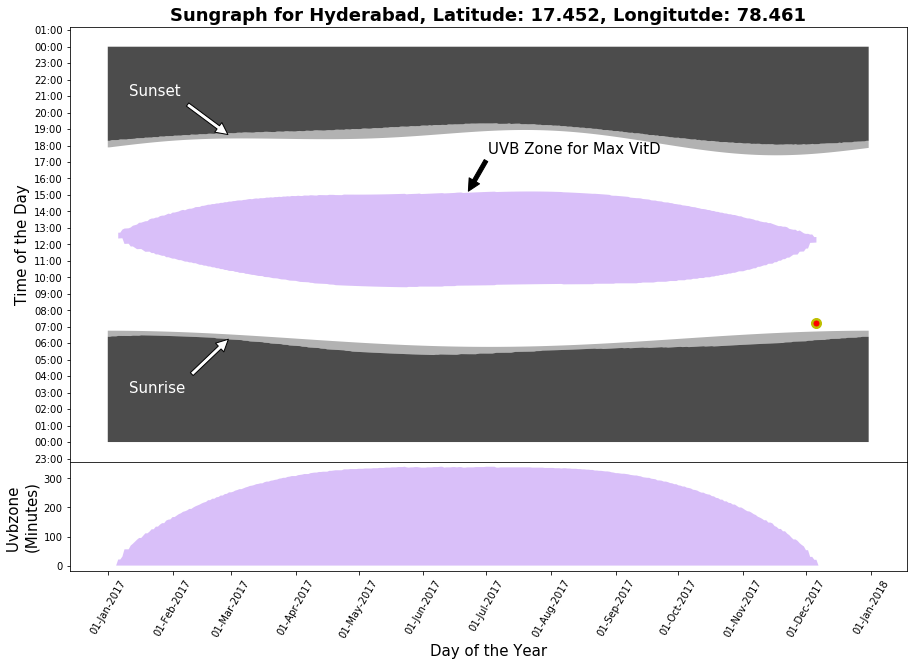

UVB Zone times for next 10 days


,day,uvbrise,uvbset,uvbzone
339,2017-12-06,2017-12-06 12:06,2017-12-06 12:26,None
340,2017-12-07,None,None,None
341,2017-12-08,None,None,None
342,2017-12-09,None,None,None
343,2017-12-10,None,None,None
344,2017-12-11,None,None,None
345,2017-12-12,None,None,None
346,2017-12-13,None,None,None
347,2017-12-14,None,None,None
348,2017-12-15,None,None,None


In [5]:
airport = 'HYD'
try:
    latitude, longitude, place = get_coordinates(airport)
except:
    print('Information for airport %s not found, please provide info manually' % airport)
    latitude, longitude, place = manual_inputs()
               
# latitude, longitude, place = (15.1, 80.0, 'Ulavapadu')

df = get_location_data(latitude, longitude)

sun_graph(latitude, longitude, place, df, saveplot=False)

print('UVB Zone times for next 10 days')
today = get_localized_time(latitude, longitude, dt.now().replace(hour=0, minute=0, second=0, microsecond=0))
next10days = df.loc[(df.day >= today)].head(10)
next10days['day'] = next10days['day'].apply(lambda x: x.strftime('%Y-%m-%d'))
next10days['uvbrise'] = next10days['uvbrise'].apply(lambda x: time_to_string(x))
next10days['uvbset'] = next10days['uvbset'].apply(lambda x: time_to_string(x))
next10days['uvbzone'] = next10days['uvbzone'].apply(lambda x: time_to_string(x, timedelta=True))
next10days[['day', 'uvbrise', 'uvbset', 'uvbzone']]
